# Adaption for ALTI+ on BART model from MUSS

Original project and models: https://github.com/facebookresearch/muss

conda environment: `alti_plus`

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
# Select GPU
# torch.cuda.set_device(4)
# torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.interactive import *
from wrappers.utils import visualize_alti
import fairseq
print('Fairseq:', fairseq.__version__)
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils

from wrappers.bart_wrapper import FairseqBartTransformerHub

import alignment.align as align

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')
warnings.simplefilter('ignore')

# from dotenv import load_dotenv
# load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/cluster/tkew/.conda/envs/alti_plus/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-26 13:32:02 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


Fairseq: 0.12.1


## Load model

In [2]:
ckpt_dir = '/scratch/tkew/ctrl_tokens/resources/models/muss_en_mined'
checkpoint_file = 'model.pt'
data_name_or_path = '.'

hub = FairseqBartTransformerHub.from_pretrained(
    ckpt_dir,
    checkpoint_file=checkpoint_file,
    data_name_or_path=data_name_or_path,
    source_lang='complex',
    target_lang='simple',
)



## Get example for analysis

In [4]:
# src_sent = '<DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.75> <REPLACEONLYLEVENSHTEIN_0.65> <LENGTHRATIO_0.75> This is extremely difficult to comprehend.'
src_sent = '<DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.85> <REPLACEONLYLEVENSHTEIN_0.65> <LENGTHRATIO_0.75> A Georgian inscription around the drum attests his name.'
src_tensor = hub.encode(src_sent)
src_tok = hub.decode(src_tensor)

# tgt_sent = 'This is very hard to understand.'
# tgt_tensor = hub.encode(tgt_sent)
# tgt_tensor = torch.concat([tgt_tensor[-1:], tgt_tensor[:-1]], dim=0)
# tgt_tok = hub.decode(tgt_tensor)

### Teacher Forcing

In [5]:
teacher_forcing = False
beam_size = 1 # NOTE: values greater than 1 cause an issue later on!
if teacher_forcing:
    print("\n\nGREEDY DECODING\n")
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor)
    pred_sent = hub.decode(pred_tensor, as_string=True)
    
else:
    tgt_tensor_free = []
    print("\n\nBEAM SEARCH\n")
    # We provide src_tensor[1:] since hub.generate internally
    # adds the language tag for generating translations
    for pred in hub.generate(src_tensor[1:], beam=1,verbose=True):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.target_dictionary.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, as_string=False)
    tgt_sent = hub.decode(tgt_tensor, as_string=True)
    
    # Forward-pass to get the 'prediction' (predicted_sentence) when the top-hypothesis is in the decoder input
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor)
    pred_sent = hub.decode(pred_tensor, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}") # result should match beam search when beam=1
    
        
print('SRC SENT:', src_sent)
print('SRC TENSOR:', src_tensor, src_tensor.shape)
print('SRC TOKENS:', src_tok)

print('TGT SENT:', tgt_sent)
print('TGT TENSOR:', tgt_tensor, tgt_tensor.shape)
print('TGT TOKENS:', tgt_tok)

print('PRED SENT:', pred_sent, 'SCORE:', score)
print('PRED TENSOR:', pred['tokens'], pred['tokens'].shape)
print('PRED TOKENS:', pred_tok)



BEAM SEARCH

S	DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.85> <REPLACEONLYLEVENSHTEIN_0.65> <LENGTHRATIO_0.75> A Georgian inscription around the drum attests his name.</s>
H	-0.4726933538913727	['Around', ' the', ' drum', ' a', ' Georgian', ' inscription', ' shows', ' his', ' name', '.', '</s>']
P	-0.8182 -0.1427 -0.0666 -1.0643 -0.4153 -0.2533 -1.8347 -0.2333 -0.1566 -0.1068 -0.1079
-0.4726933538913727 	 Around the drum a Georgian inscription shows his name.</s>


GREEDY DECODING with hypothesis 1

Predicted sentence: 	 Around the drum a Georgian inscription states his name.</s>
SRC SENT: <DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.85> <REPLACEONLYLEVENSHTEIN_0.65> <LENGTHRATIO_0.75> A Georgian inscription around the drum attests his name.
SRC TENSOR: tensor([41552, 41372,  9309, 23451,   565,  4629,  1691,  9662,  3732,   500,
         2571,  6454,  1215,   288,     4,   306, 15698, 28696, 42204, 10644,
        10227,   500,  2571,  6454,  1215,   288,     4,  4531, 15698, 

## ALTI analysis

### ALTI of the encoder

To check the mixing of information inside the decoder. Visualization show with and without main diagonal

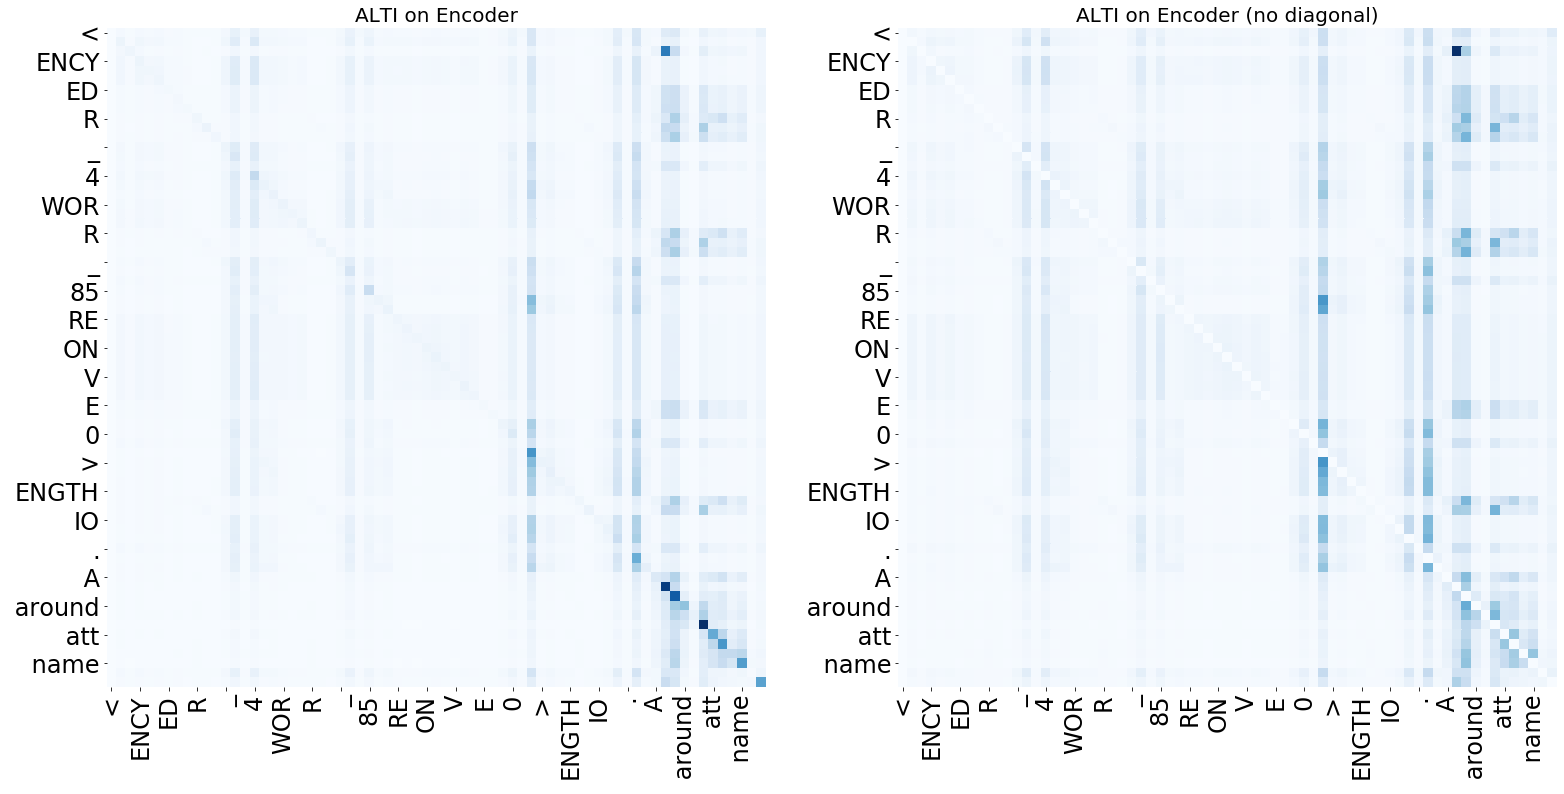

In [6]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1',
                                                        norm_mode='min_sum')['encoder.self_attn']
layer = -1                                                        
# Encoder self-attention relevances in last layer (full encoder ALTI)
fig = plt.figure(figsize=(26, 14))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])
relevances_enc_self_attn_last = relevances_enc_self_attn[layer]
relevances_enc_self_attn_last_no_diag = relevances_enc_self_attn_last - torch.diag(relevances_enc_self_attn_last.diag())
df = pd.DataFrame(relevances_enc_self_attn_last.cpu().detach().numpy(),columns=src_tok, index=src_tok)
sns.set(font_scale=0.7)
sns.heatmap(df,cmap="Blues",ax=ax_left,square=True, cbar=False)
ax_left.set_title('ALTI on Encoder', fontsize=20)

df = pd.DataFrame(relevances_enc_self_attn_last_no_diag.cpu().detach().numpy(),columns=src_tok, index=src_tok)
sns.heatmap(df,cmap="Blues",ax=ax_right,square=True, cbar=False)
ax_right.set_title('ALTI on Encoder (no diagonal)', fontsize=20)
plt.gcf().subplots_adjust(bottom=0.2)

Attention weights (raw) in the cross attention at selected layer.
Corresponds to Figure 8-a of the paper

torch.Size([12, 11, 69])
['<', 'DEP', 'END', 'ENCY', 'T', 'RE', 'ED', 'EP', 'TH', 'R', 'AT', 'IO', '_', '0', '.', '4', '>', ' <', 'WOR', 'DR', 'ANK', 'R', 'AT', 'IO', '_', '0', '.', '85', '>', ' <', 'RE', 'PL', 'ACE', 'ON', 'LY', 'LE', 'V', 'ENS', 'HT', 'E', 'IN', '_', '0', '.', '65', '>', ' <', 'L', 'ENGTH', 'R', 'AT', 'IO', '_', '0', '.', '75', '>', ' A', ' Georgian', ' inscription', ' around', ' the', ' drum', ' att', 'ests', ' his', ' name', '.', '</s>'] 69
['</s>', 'Around', ' the', ' drum', ' a', ' Georgian', ' inscription', ' shows', ' his', ' name', '.'] 11
['Around', ' the', ' drum', ' a', ' Georgian', ' inscription', ' states', ' his', ' name', '.', '</s>'] 11


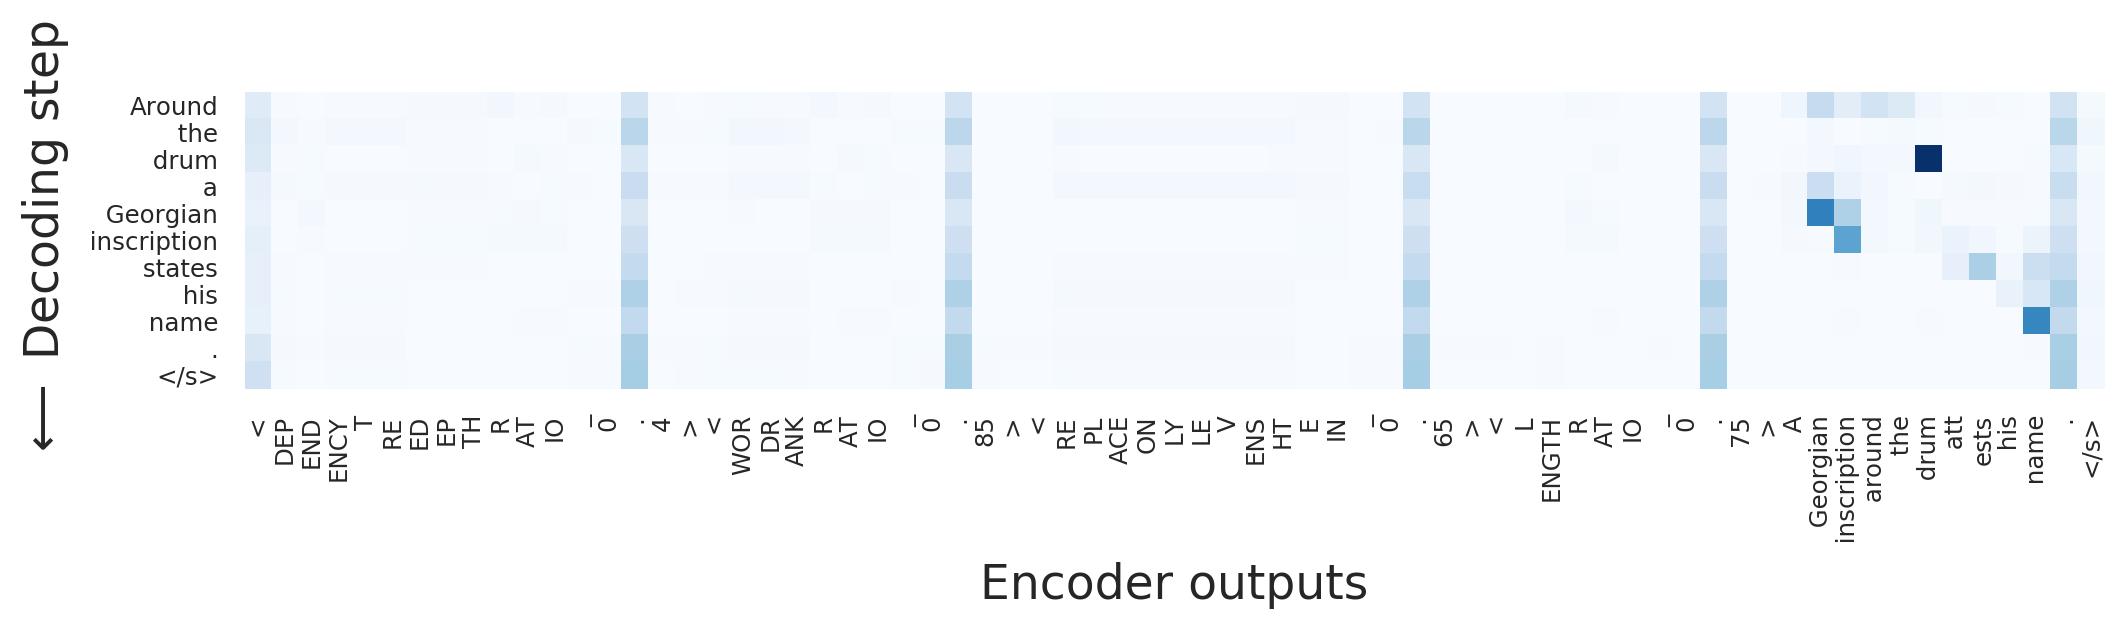

In [7]:
# attn_w, norm_mode='sum_one'
cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w',
                                                                norm_mode='sum_one')['decoder.encoder_attn'])

layer = -2
print(cross_attn_contributions.shape)

cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(12,12),dpi=200)


print(src_tok, len(src_tok))
print(tgt_tok, len(tgt_tok))
print(pred_tok, len(pred_tok))

df = pd.DataFrame(cross_attn_contributions[layer], columns=src_tok, index=pred_tok)
sns.set(font_scale=0.8)
# df
# s = sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues", square=True, cbar=False)
s.set_xlabel('Encoder outputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False)
# plt.xticks(rotation=60);

Cross-attention contributions $[\mathbf{C}_{\widetilde{\mathbf{y}}\gets\mathbf{e}};\mathbf{C}_{\widetilde{\mathbf{y}}\gets\widetilde{\bm{y}}^{s}_{t}}]$ of the encoder outputs $\mathbf{e}$ and residual $\widetilde{\bm y}_{t}^{s}$ to the decoder layer output.

Corresponds to Figure 8-b of the paper.

mean residual 0.84295976 std 0.057789832


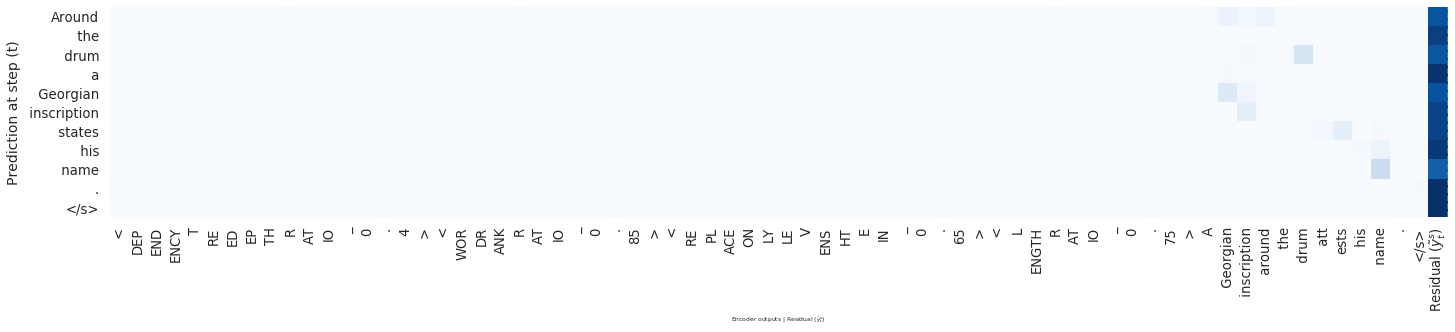

In [8]:
cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor,
                                        tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])

cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()

layer = -1
plt.figure(figsize=(24,12))

df = pd.DataFrame(cross_attn_contributions[layer], columns=src_tok + ['Residual'], index=pred_tok)
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel(r'Encoder outputs | Residual $(\tilde{y}^{s}_{t})$', fontsize=6)
s.set_ylabel('Prediction at step (t)', fontsize=14)

plt.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False);
plt.xticks(ticks = plt.gca().get_xticks(), labels=src_tok + [r'Residual $(\tilde{y}^{s}_{t})$'])

plt.axvline(x = len(src_tok)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

print('mean residual',df['Residual'].mean(), 'std', df['Residual'].std())


### ALTI+

ALTI+ for the entire model. Last layer heatmap shows relevances of input tokens to the model prediction: $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{x}}$ | $\mathbf{R}^{\text{model}}_{\widetilde{\mathbf{y}}_t \gets \mathbf{\mathbf{y}_{<t}}}$

In [9]:
# total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']

In [10]:
print(src_tensor.shape)
print(tgt_tensor.shape)
print(pred_tensor.shape)

torch.Size([69])
torch.Size([11])
torch.Size([11])


In [11]:
total_alti = hub.get_contribution_rollout(src_tensor, tgt_tensor,
                                            'l1', norm_mode='min_sum')['total']
print(total_alti.shape)

torch.Size([12, 11, 80])


In [12]:
## see below to manually generate plots and save

# alti_result, src_tok_, pred_tok_ = visualize_alti(total_alti, src_tok, tgt_tok, pred_tok,
#                                                   word_level=False, alignment=False, all_layers=True)

In [19]:
# alti_result, src_tok_, pred_tok_ = visualize_alti(total_alti, src_tok, tgt_tok, pred_tok,
#                                                   word_level=True, alignment=False, all_layers=False)

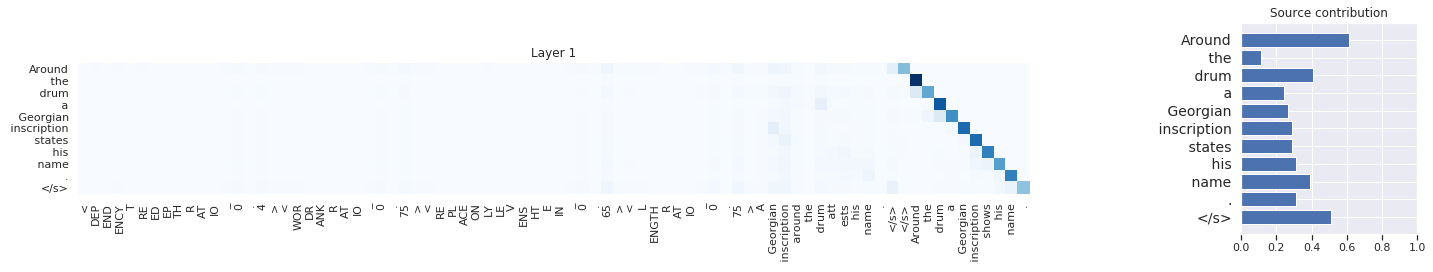

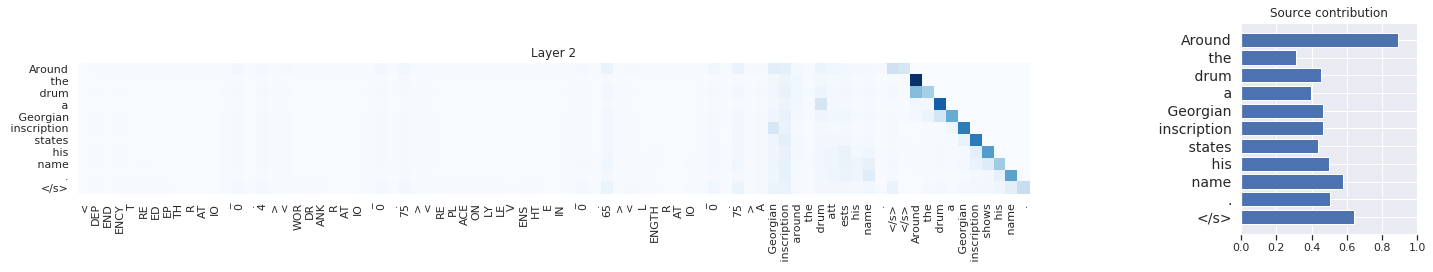

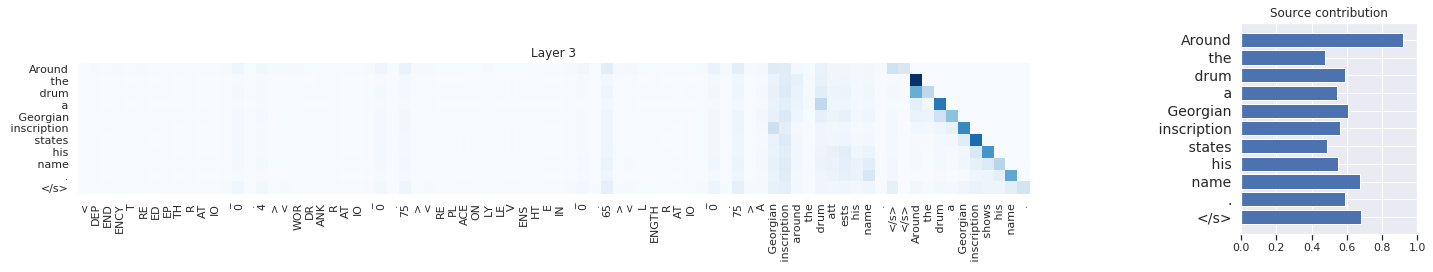

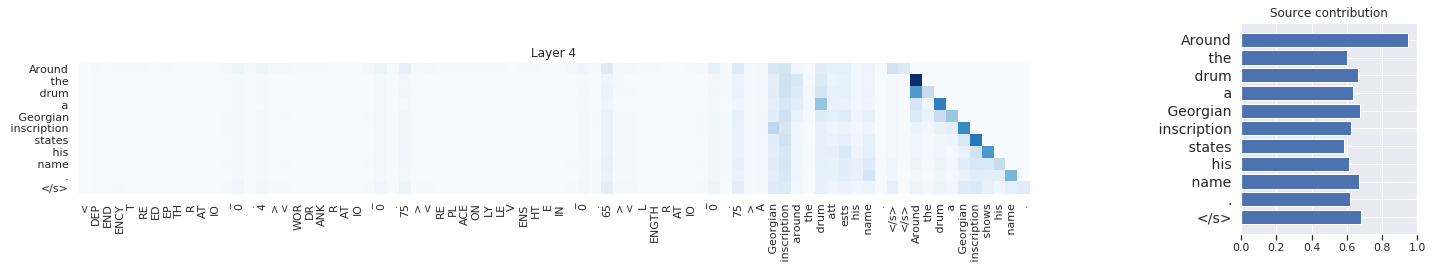

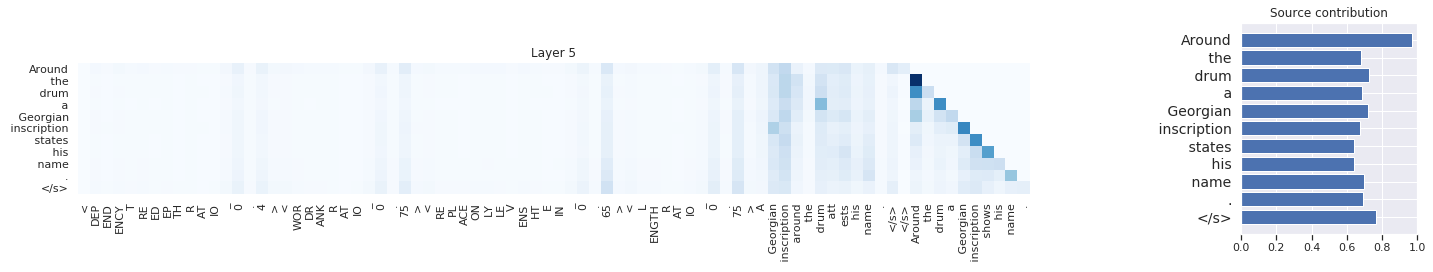

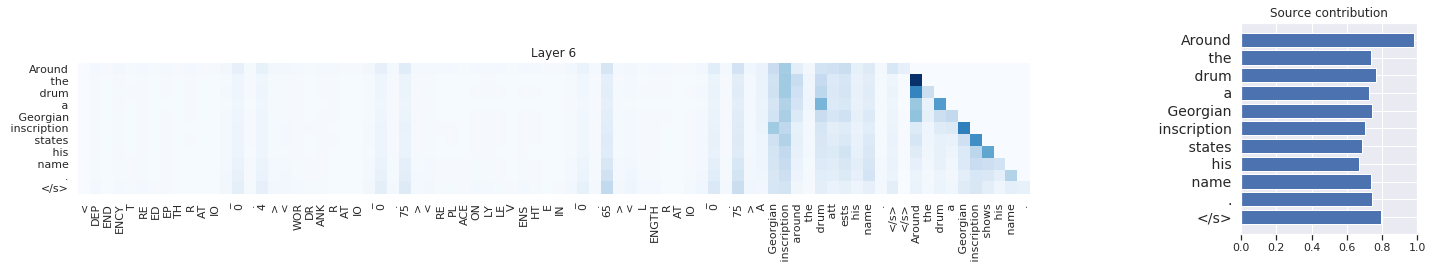

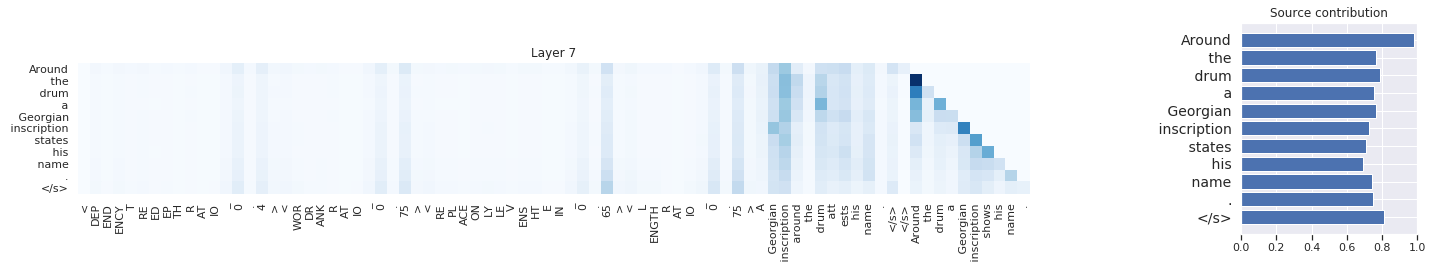

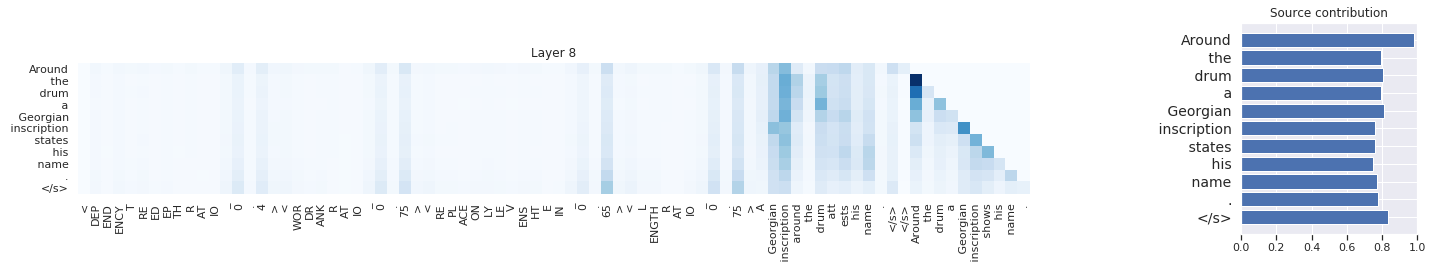

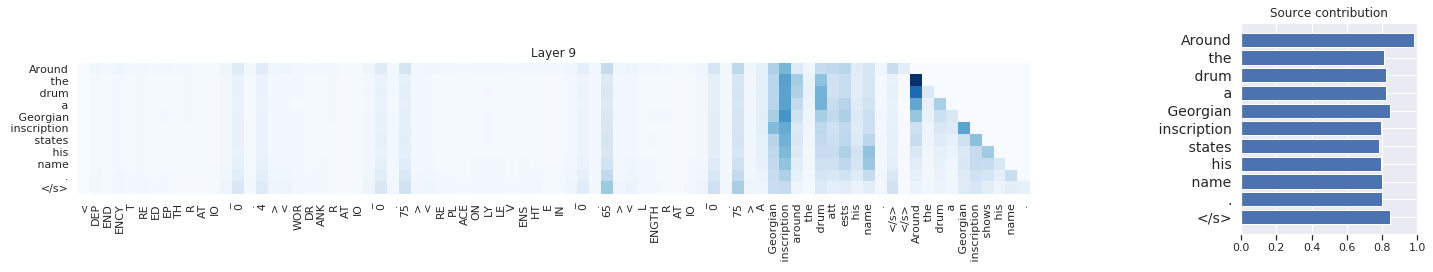

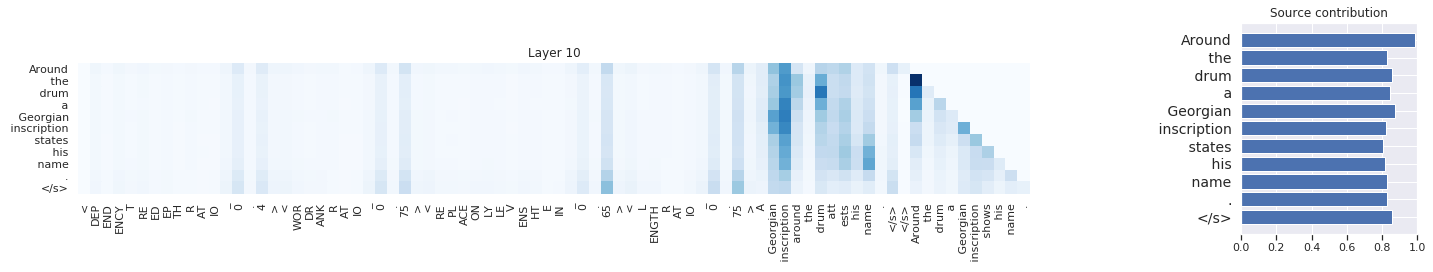

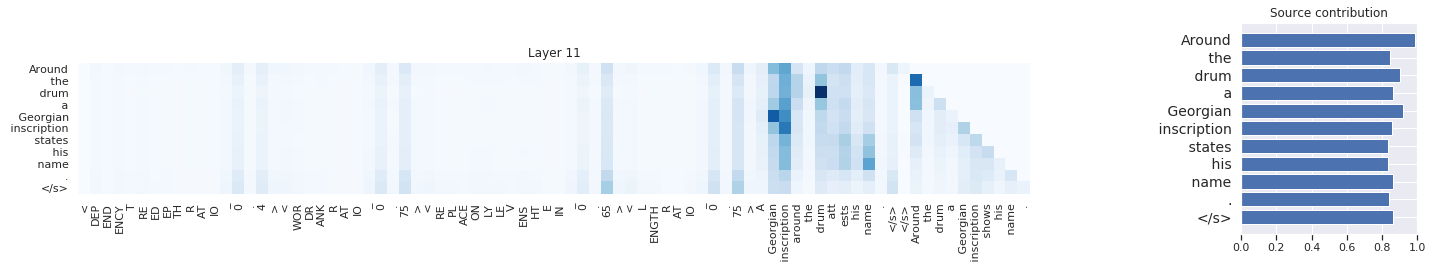

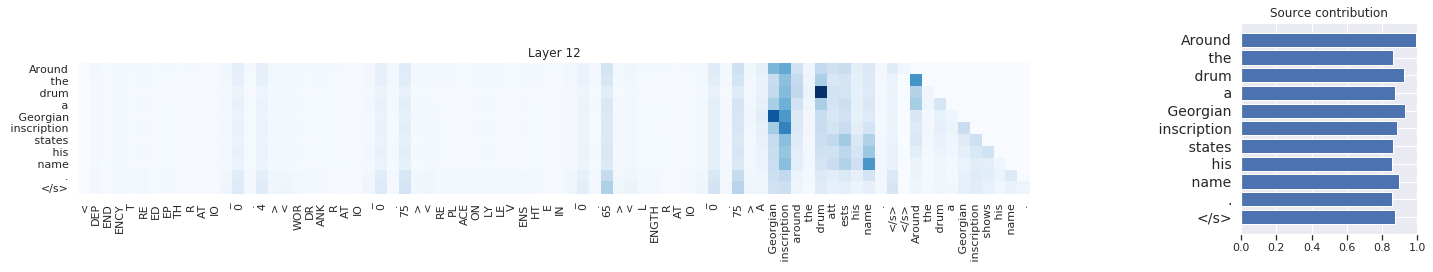

In [43]:
sns.set(font_scale=1.0)
# could plot all on a single figure...
for layer in range(0, total_alti.shape[0]):
    fig = plt.figure(figsize=(24, 12))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_alti[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = src_tok + tgt_tok, index = pred_tok)
    sns.heatmap(df, cmap="Blues", square=True, ax=ax_main, cbar=False) #Reds, center=0
    
    # side plot
    src_contribution = contributions_rollout_layer_np[:, :src_tensor.size(0)].sum(-1)
    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = pred_tok)
    #sns.set_style("white")
    ax_yDist.barh(range(0, len(pred_tok)), df_src_contribution.src_contribution, align='center')
#     plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = tgt_tok + ['<EOS>'],fontsize='14')
    plt.yticks(ticks = range(0, len(pred_tok)) ,labels=pred_tok, fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer+1))
    ax_yDist.set_title('Source contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
#     plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig(f'./plots/ex_a-bart-muss_alti-plus_l{layer}.png')

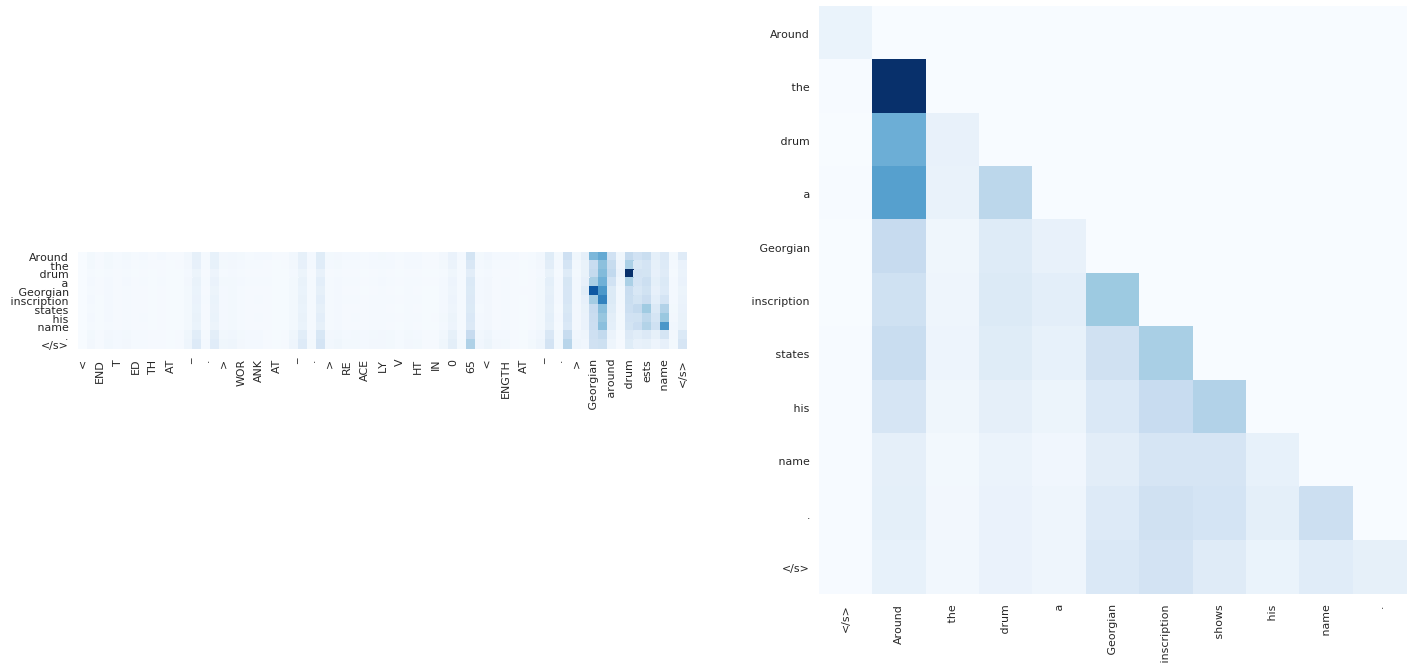

In [44]:
# Separated plots for ALTI+ in last layer
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.05)#0.015
ax_left = plt.subplot(gs[0, 0])
ax_right = plt.subplot(gs[0, 1])

df = pd.DataFrame(contributions_rollout_layer_np[:, :len(src_tok)], columns=src_tok, index=pred_tok)
sns.set(font_scale=0.6)
s = sns.heatmap(df, cmap="Blues", square=True, ax=ax_left, cbar=False)

df = pd.DataFrame(contributions_rollout_layer_np[:,len(src_tok):len(src_tok)+len(tgt_tok)], columns=tgt_tok, index=pred_tok)
s = sns.heatmap(df, cmap="Blues", square=True, ax=ax_right, cbar=False)
plt.gcf().subplots_adjust(bottom=0.2)
# s.set_xlabel('TGT sequence')
# s.set_ylabel('Prediction Timesteps')

# Merging contributions to word-level

In [45]:
def merge_contributions(src_tokens, tgt_tokens, token_contributions):
    
    
    src_words = ''.join(src_tokens[:-1]+ [' </s>']).split()
    tgt_words = ''.join(['</s> '] + tgt_tokens[1:]).split()
    words = src_words + tgt_words
    print(words)
    
    word_i = 0
    word_to_bpe = [[] for _ in range(len(words))]
    print(word_to_bpe)
    for bpe_i, token in enumerate(src_tokens + tgt_tokens):
#         print(token)
        if token == '</s>' or token.startswith("__") or token.startswith(" "):
            word_i += 1
#         print(token, word_i)
        word_to_bpe[word_i-1].append(bpe_i)
    
    words_contrib = []
    for word in word_to_bpe:
        word_contrib_sum = 0
        for subword in word:
            word_contrib_sum += word_bpe_contributions[subword]
        words_contrib.append(word_contrib_sum)
    
    return words, words_contrib

# print(''.join(src_tok), ''.join(tgt_tok))
word_bpe_contributions = list(total_alti[-1][-1].detach().cpu().numpy())
words_list, words_contrib = merge_contributions(src_tok, tgt_tok, word_bpe_contributions)
print(words_list)
print(words_contrib)

['<DEPENDENCYTREEDEPTHRATIO_0.4>', '<WORDRANKRATIO_0.75>', '<REPLACEONLYLEVENSHTEIN_0.65>', '<LENGTHRATIO_0.75>', 'A', 'Georgian', 'inscription', 'around', 'the', 'drum', 'attests', 'his', 'name.', '</s>', '</s>', 'Around', 'the', 'drum', 'a', 'Georgian', 'inscription', 'shows', 'his', 'name.']
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
['<DEPENDENCYTREEDEPTHRATIO_0.4>', '<WORDRANKRATIO_0.75>', '<REPLACEONLYLEVENSHTEIN_0.65>', '<LENGTHRATIO_0.75>', 'A', 'Georgian', 'inscription', 'around', 'the', 'drum', 'attests', 'his', 'name.', '</s>', '</s>', 'Around', 'the', 'drum', 'a', 'Georgian', 'inscription', 'shows', 'his', 'name.']
[0.12907121353782713, 0.1882314805407077, 0.17074779188260436, 0.008901586756110191, 0.04492131620645523, 0.04710221663117409, 0.010191082954406738, 0.0036589133087545633, 0.026230115443468094, 0.03717482089996338, 0.01238457765430212, 0.025024532340466976, 0.037877995520830154, 0.011544968001544476, 0.0043277

## Word-word alignments (source-target) from contributions

Currently only works for teacher forcing

In [49]:
src_word_sent = src_sent
print(src_word_sent)
print(src_tok)
src_tok_str = ' '.join(src_tok[:-1]).replace('  ', ' @@')
print(src_tok_str)

# target_sent[0] = '</s>▁'#▁__en__'
# print(tgt_tok)
tgt_tok_str = ' '.join(tgt_tok[1:]).replace('  ', ' @@')
tgt_word_sent = tgt_sent
print(tgt_tok_str)
print(tgt_word_sent)

<DEPENDENCYTREEDEPTHRATIO_0.4> <WORDRANKRATIO_0.75> <REPLACEONLYLEVENSHTEIN_0.65> <LENGTHRATIO_0.75> A Georgian inscription around the drum attests his name.
['<', 'DEP', 'END', 'ENCY', 'T', 'RE', 'ED', 'EP', 'TH', 'R', 'AT', 'IO', '_', '0', '.', '4', '>', ' <', 'WOR', 'DR', 'ANK', 'R', 'AT', 'IO', '_', '0', '.', '75', '>', ' <', 'RE', 'PL', 'ACE', 'ON', 'LY', 'LE', 'V', 'ENS', 'HT', 'E', 'IN', '_', '0', '.', '65', '>', ' <', 'L', 'ENGTH', 'R', 'AT', 'IO', '_', '0', '.', '75', '>', ' A', ' Georgian', ' inscription', ' around', ' the', ' drum', ' att', 'ests', ' his', ' name', '.', '</s>']
< DEP END ENCY T RE ED EP TH R AT IO _ 0 . 4 > @@< WOR DR ANK R AT IO _ 0 . 75 > @@< RE PL ACE ON LY LE V ENS HT E IN _ 0 . 65 > @@< L ENGTH R AT IO _ 0 . 75 > @@A @@Georgian @@inscription @@around @@the @@drum @@att ests @@his @@name .
Around @@the @@drum @@a @@Georgian @@inscription @@shows @@his @@name .
</s>Around the drum a Georgian inscription shows his name.


In [50]:
tgt_splited_bpe_sent = tgt_word_sent.split()
print(tgt_splited_bpe_sent)
splited_word_sent = tgt_tok_str.split()
print(splited_word_sent)

['</s>Around', 'the', 'drum', 'a', 'Georgian', 'inscription', 'shows', 'his', 'name.']
['Around', '@@the', '@@drum', '@@a', '@@Georgian', '@@inscription', '@@shows', '@@his', '@@name', '.']


In [51]:
contribution_pred_src = contributions_rollout_layer_np[:,:len(src_tok)]#[:,1:] # delete first row
print(contribution_pred_src.shape)

print(src_tok_str.split())
print(src_word_sent.split())

src_word_to_bpe = align.convert_bpe_word(src_tok_str.split(), src_word_sent.split())
print(src_word_to_bpe)

print(tgt_tok_str.split())
print(tgt_word_sent.split())
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str.split(), tgt_word_sent.split())

contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)

contributions_word_word.shape

(11, 69)
['<', 'DEP', 'END', 'ENCY', 'T', 'RE', 'ED', 'EP', 'TH', 'R', 'AT', 'IO', '_', '0', '.', '4', '>', '@@<', 'WOR', 'DR', 'ANK', 'R', 'AT', 'IO', '_', '0', '.', '75', '>', '@@<', 'RE', 'PL', 'ACE', 'ON', 'LY', 'LE', 'V', 'ENS', 'HT', 'E', 'IN', '_', '0', '.', '65', '>', '@@<', 'L', 'ENGTH', 'R', 'AT', 'IO', '_', '0', '.', '75', '>', '@@A', '@@Georgian', '@@inscription', '@@around', '@@the', '@@drum', '@@att', 'ests', '@@his', '@@name', '.']
['<DEPENDENCYTREEDEPTHRATIO_0.4>', '<WORDRANKRATIO_0.75>', '<REPLACEONLYLEVENSHTEIN_0.65>', '<LENGTHRATIO_0.75>', 'A', 'Georgian', 'inscription', 'around', 'the', 'drum', 'attests', 'his', 'name.']
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], [57], [58], [59], [60], [61], [62], [63, 64], [65], [66, 67], [68]]
['Around', '@@the', '@@drum', '@@a', '@@Georgian', '@@in

(10, 14)

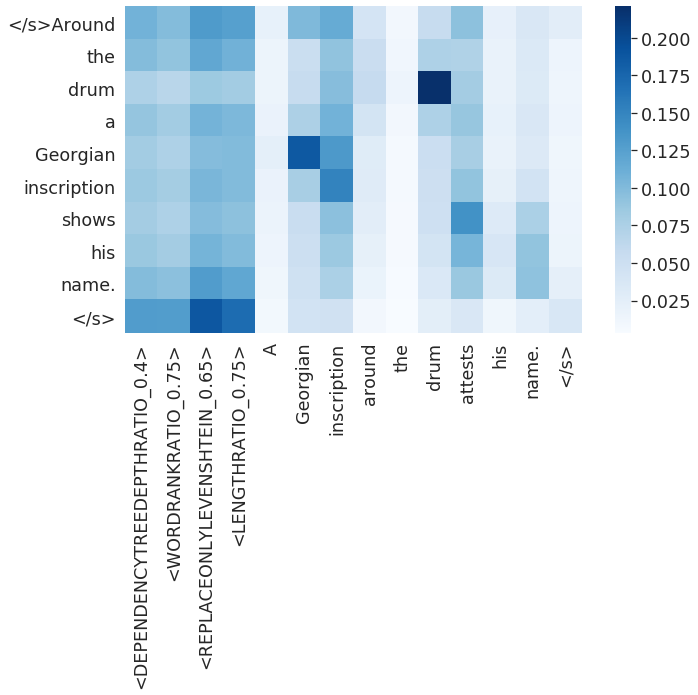

In [52]:
## Soft alignment
plt.figure(figsize=(12,6))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

[ 2  2  9  6  5  6 10  2  2  2]


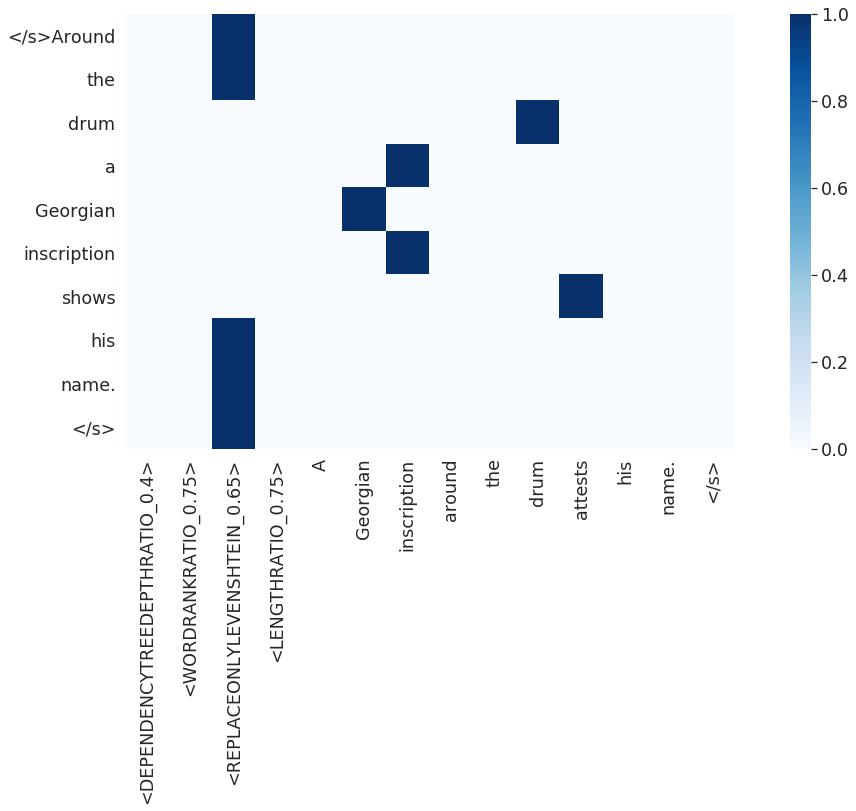

In [53]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
print(a_argmax)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);